In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

In [2]:
from kgfe import gene_names

In [3]:
import igraph as ig

## Load SPOKE

In [4]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [5]:
gene_names.get_id('LILRA3')

11026

In [6]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')
spoke_graph_ud = kgfe.graph_info.largest_component(spoke_graph_ud)

In [7]:
genes_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Gene')

In [8]:
disease_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Disease')

In [9]:
disease_to_ids['DOID:9119']

'2166630'

## List of Venetoclax genes

In [10]:
genes_small = 'BCL2, NFKB2, GATA2, NPC2'.split(', ')
gene_ncbi_ids = gene_names.get_ids(genes_small)

In [11]:
genes_venetoclax = 'FGD4 MIR4519 NPC2 GATA2 CASC10 POU6F1 BCL2 BECN1 C1QA SF3B2 IGF2R DNAJC1 ECHDC3 MIR940 GDF11 RBPJ MTSS1 FNTA'
genes_venetoclax += 'CTCF NFKB2 FGD4 RPS10 LILRB2 COX6A1 C1QA FOXO1 LILRA3 RELB GOLGA8J LEF1'

genes_venetoclax = genes_venetoclax.split()
genes_venetoclax_ncbi_ids = []
for g in genes_venetoclax:
    try:
        genes_venetoclax_ncbi_ids.append(gene_names.get_id(g))
    except:
        pass

In [12]:
genes_venetoclax_spoke_ids = [genes_to_ids[g] for g in genes_venetoclax_ncbi_ids if g in genes_to_ids] + ['2166630']

In [13]:
print('venetoclax genes:', len(genes_venetoclax), 'spoke-venetoclax genes:', len(genes_venetoclax_spoke_ids))

venetoclax genes: 29 spoke-venetoclax genes: 26


In [14]:
gene_ids = [genes_to_ids[g] for g in gene_ncbi_ids] + ['2166630']

## Calculate null model stats for Venetoclax genes

In [15]:
venetoclax_genes = [genes_to_ids[g] for g in gene_ncbi_ids]

In [17]:
venetoclax_genes_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud, list(set(venetoclax_genes)),
                                                         target_nodes=['2166630'])

In [18]:
venetoclax_genes_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud, 'Gene',\
                                                                 len(venetoclax_genes),\
                                                                 use_degree_sampling=True,\
                                                                 input_id_set=venetoclax_genes,
                                                                 target_nodes=['2166630'])

In [22]:
venetoclax_genes_null_results = pd.DataFrame(venetoclax_genes_null_results)

In [23]:
import matplotlib.pyplot as plt

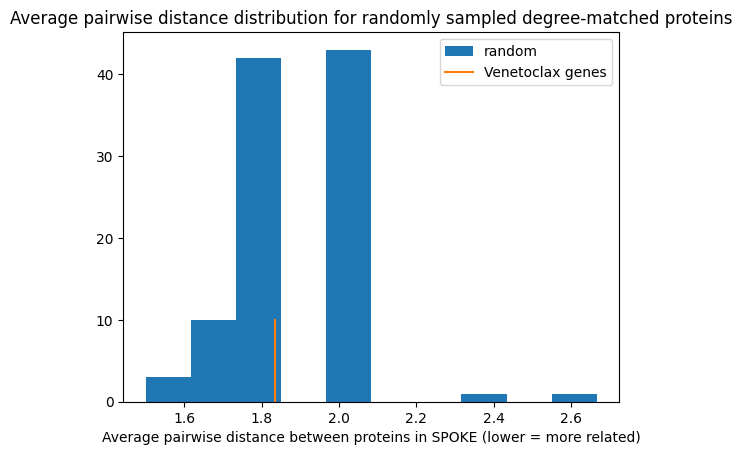

In [24]:
plt.hist(venetoclax_genes_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled degree-matched proteins')
plt.plot([venetoclax_genes_stats['average_pairwise_distance'], venetoclax_genes_stats['average_pairwise_distance']],
         [0, 10], label='Venetoclax genes')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

TODO: do this for proteins as well, do this for a reduced graph (spoke-2021-bio?)

## Get Steiner Tree for AML genes on SPOKE-2021

In [25]:
gene_st, gene_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                    gene_ids,
                                                                         method='takahashi')

In [26]:
import ipycytoscape
graph_style = [{
                        'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [27]:
undirected = ipycytoscape.CytoscapeWidget()
gene_subgraph_nx = gene_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in gene_subgraph_nx.nodes.items()}
gene_subgraph_nx = nx.relabel_nodes(gene_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(gene_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [28]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

### Steiner tree for "full" venetoclax genes on SPOKE-2021

In [29]:
gene_st, gene_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                    genes_venetoclax_spoke_ids,
                                                                         method='takahashi')

In [30]:
undirected = ipycytoscape.CytoscapeWidget()
gene_subgraph_nx = gene_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in gene_subgraph_nx.nodes.items()}
gene_subgraph_nx = nx.relabel_nodes(gene_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(gene_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [31]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

## Merging graphs - do stuff on combined SIGNOR, reactome, kegg data

In [32]:
kgfe.graph_info.get_available_graphs()
# consider SIGNOR, kegg, reactome

['reactome_ppis.csv.gz',
 'uniprot_genes.csv',
 'spoke_2021.jsonl.gz',
 'kegg_pathway_data.csv',
 'hsa04930.csv',
 'reactome_genes_chems.csv.gz',
 'SIGNOR_formated.tsv',
 'kegg_interaction_data.csv',
 'KEGG_signaling.tsv',
 'msigdb']

In [33]:
kegg_signaling = kgfe.graph_info.load_graph('KEGG_signaling.tsv')

In [34]:
kegg_signaling.predicate = 'kegg_' + kegg_signaling.predicate

In [35]:
signor_signaling = kgfe.graph_info.load_graph('SIGNOR_formated.tsv')

In [36]:
signor_signaling.predicate = 'signor_' + signor_signaling.predicate

In [37]:
reactome_genes_chems = kgfe.graph_info.load_graph('reactome_genes_chems.csv.gz')

/home/yjzhang/isb/kg_feature_engineering/src/kgfe/graph_info.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [38]:
reactome_genes_chems.predicate = 'reactome_' + reactome_genes_chems.predicate

In [39]:
merged_graph = pd.concat([kegg_signaling, signor_signaling, reactome_genes_chems], axis=0)

In [40]:
biggim_graph = kgfe.graph_info.df_to_graph(merged_graph)

In [41]:
len(biggim_graph.vs)

24839

In [42]:
genes_to_ids = kgfe.graph_info.get_names_to_ids(biggim_graph, category='Gene')

## Get Steiner Tree for AML genes on combined graph

In [43]:
gene_ids = [genes_to_ids[g] for g in genes_small]

In [44]:
genes_venetoclax_ids = [genes_to_ids[g] for g in genes_venetoclax if g in genes_to_ids]

In [45]:
gene_st, gene_subgraph = kgfe.explanations.steiner_tree_subgraph(biggim_graph,
                                                                    gene_ids,
                                                                         method='takahashi')

In [46]:
graph_style = [{
                        'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[predicate]',
                         'style': {
                             'label': 'data(predicate)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [47]:
undirected = ipycytoscape.CytoscapeWidget()
gene_subgraph_nx = gene_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in gene_subgraph_nx.nodes.items()}
gene_subgraph_nx = nx.relabel_nodes(gene_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(gene_subgraph_nx)
for node in undirected.graph.nodes:
    if 'name' in node.data:
        node.data['id'] = node.data['name']
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [48]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [49]:
gene_st, gene_subgraph = kgfe.explanations.steiner_tree_subgraph(biggim_graph,
                                                                    genes_venetoclax_ids,
                                                                         method='takahashi')

### Steiner tree for "full" venetoclax genes on merged graph

In [50]:
undirected = ipycytoscape.CytoscapeWidget()
gene_subgraph_nx = gene_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in gene_subgraph_nx.nodes.items()}
gene_subgraph_nx = nx.relabel_nodes(gene_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(gene_subgraph_nx)
for node in undirected.graph.nodes:
    if 'name' in node.data:
        node.data['id'] = node.data['name']
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [51]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…